In [8]:
import pandas as pd
import numpy as np

import pickle

from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

import matplotlib.pyplot as plt
import os
import joblib
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

In [17]:
main_df = pd.read_csv("main_data.csv")
estimation_df = pd.read_csv("estimation_data.csv")
oos_df = pd.read_csv("oos_data.csv")

In [10]:
trading_days_count = main_df.groupby('PERMNO').size()
display(len(trading_days_count))

50

In [15]:

def directional_up_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    up_mask = y_true[1:] > y_true[:-1]
    pred_up_mask = y_pred[1:] > y_pred[:-1]
    correct_up = (up_mask & pred_up_mask).sum()
    total_up = up_mask.sum()
    return correct_up / total_up if total_up != 0 else np.nan

def directional_down_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    down_mask = y_true[1:] < y_true[:-1]
    pred_down_mask = y_pred[1:] < y_pred[:-1]
    correct_down = (down_mask & pred_down_mask).sum()
    total_down = down_mask.sum()
    return correct_down / total_down if total_down != 0 else np.nan

# Function for directional accuracy
def directional_accuracy(y_true, y_pred):
    actual_diff = y_true.values[1:] - y_true.values[:-1]
    predicted_diff = y_pred[1:] - y_pred[:-1]
    return (actual_diff * predicted_diff > 0).sum() / len(actual_diff)

# Define models to evaluate
def get_models(n_components=3):
    return {
        "OLS": make_pipeline(StandardScaler(), LinearRegression()),
        "Ridge": make_pipeline(StandardScaler(), Ridge()),
        "Lasso": make_pipeline(StandardScaler(), Lasso()),
        "PLS": PLSRegression(n_components=n_components),  # PLS scales internally
        "PCR": make_pipeline(StandardScaler(), PCA(n_components=n_components), LinearRegression()),
        "RF": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)  # No scaling needed
    }


# Directional accuracy functions
def directional_up_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    up_mask = y_true[1:] > y_true[:-1]
    pred_up_mask = y_pred[1:] > y_pred[:-1]
    correct_up = (up_mask & pred_up_mask).sum()
    total_up = up_mask.sum()
    return correct_up / total_up if total_up != 0 else np.nan

def directional_down_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    down_mask = y_true[1:] < y_true[:-1]
    pred_down_mask = y_pred[1:] < y_pred[:-1]
    correct_down = (down_mask & pred_down_mask).sum()
    total_down = down_mask.sum()
    return correct_down / total_down if total_down != 0 else np.nan



USED PICKLE FOR ERROR METRIC

In [18]:

LAGS = 5
rolling_windows = [5, 21, 252, 512]
lag_features = [f'EXCESS_RET_lag_{i}' for i in range(1, LAGS + 1)]
model_names = ["OLS", "Ridge", "Lasso", "PLS", "PCR", "RF"]
pickle_dir = "SavedPickleModels"

# Ensure the pickle directory exists
os.makedirs(pickle_dir, exist_ok=True)

# Model dictionary
model_dict = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(alpha=1e-5),
    "PLS": PLSRegression(n_components=min(len(lag_features) + 1, 5)),
    "PCR": make_pipeline(StandardScaler(), PCA(n_components=min(len(lag_features) + 1, 5)), LinearRegression()),
    "RF": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
}

# Loop over each rolling window
for w in rolling_windows:
    feature = f'rolling_mean_{w}'
    feature_set = lag_features + [feature]

    train = estimation_df.dropna(subset=feature_set + ['EXCESS_RET']).copy()
    X_train = train[feature_set]
    y_train = train['EXCESS_RET']
    for name in model_names:
        model = model_dict[name]

        # Fit model
        model.fit(X_train, y_train)

        # Save model
        model_path = os.path.join(pickle_dir, f"{name}_window{w}.pkl")
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)

        print(f"Saved: {model_path}")


Saved: SavedPickleModels\OLS_window5.pkl
Saved: SavedPickleModels\Ridge_window5.pkl
Saved: SavedPickleModels\Lasso_window5.pkl
Saved: SavedPickleModels\PLS_window5.pkl
Saved: SavedPickleModels\PCR_window5.pkl
Saved: SavedPickleModels\RF_window5.pkl
Saved: SavedPickleModels\OLS_window21.pkl
Saved: SavedPickleModels\Ridge_window21.pkl
Saved: SavedPickleModels\Lasso_window21.pkl
Saved: SavedPickleModels\PLS_window21.pkl
Saved: SavedPickleModels\PCR_window21.pkl
Saved: SavedPickleModels\RF_window21.pkl
Saved: SavedPickleModels\OLS_window252.pkl
Saved: SavedPickleModels\Ridge_window252.pkl
Saved: SavedPickleModels\Lasso_window252.pkl
Saved: SavedPickleModels\PLS_window252.pkl
Saved: SavedPickleModels\PCR_window252.pkl
Saved: SavedPickleModels\RF_window252.pkl
Saved: SavedPickleModels\OLS_window512.pkl
Saved: SavedPickleModels\Ridge_window512.pkl
Saved: SavedPickleModels\Lasso_window512.pkl
Saved: SavedPickleModels\PLS_window512.pkl
Saved: SavedPickleModels\PCR_window512.pkl
Saved: SavedPick

In [19]:
# Configuration
LAGS = 5
rolling_windows = [5, 21, 252, 512]
lag_features = [f'EXCESS_RET_lag_{i}' for i in range(1, LAGS + 1)]
model_names = ["OLS", "Ridge", "Lasso", "PLS", "PCR", "RF"]
pickle_dir = "SavedPickleModels"
# estimation_df as training data  
# oos_df as test data 

# Results container
results = []
oos_df_pred = oos_df.copy()

# Loop through windows and model files
for w in rolling_windows:
    feature = f'rolling_mean_{w}'
    feature_set = lag_features + [feature]

    test = oos_df.dropna(subset=feature_set + ['EXCESS_RET']).copy()
    X_test = test[feature_set]
    y_test = test['EXCESS_RET']

    for name in model_names:
        model_path = os.path.join(pickle_dir, f"{name}_window{w}.pkl")
        pred_col = f"{name}_predicted_window{w}"
        
        if not os.path.exists(model_path):
            print(f"Model {name}_window{w}.pkl not found. Skipping.")
            continue

        try:
            with open(model_path, 'rb') as f:
                model = pickle.load(f)

            preds = model.predict(X_test)
            test_temp = test[['PERMNO', 'date']].copy()
            test_temp[pred_col] = preds

            oos_df_pred = oos_df_pred.merge(test_temp, on=['PERMNO', 'date'], how='left')
            results.append({
                'Model': name,
                'Rolling Window': w,
                'R2': r2_score(y_test, preds),
                'MSE': mean_squared_error(y_test, preds),
                'MAE': mean_absolute_error(y_test, preds),
                'Directional Accuracy': directional_accuracy(y_test, preds),
                'Directional Up': directional_up_accuracy(y_test, preds),
                'Directional Down': directional_down_accuracy(y_test, preds)
            })

        except Exception as e:
            results.append({
                'Model': name,
                'Rolling Window': w,
                'R2': np.nan,
                'MSE': np.nan,
                'MAE': np.nan,
                'Directional Accuracy': np.nan,
                'Directional Up': np.nan,
                'Directional Down': np.nan,
                'Error': str(e)
            })

# Save results
results_linear_df = pd.DataFrame(results)
display(results_linear_df)
os.makedirs("Results", exist_ok=True)

oos_df_pred.to_csv("results_oos_pred.csv", index=False)
print("Saved predictions to top50_outofsample_pred.csv")

results_linear_df.to_csv("Results/results_linear_new_directional.csv", index=False)
print("Saved results to Results/results_linear_new_directional.csv")


,Model,Rolling Window,R2,MSE,MAE,Directional Accuracy,Directional Up,Directional Down
0,OLS,5,-0.002434,0.001067,0.018193,0.572055,0.574511,0.571802
1,Ridge,5,-0.002424,0.001067,0.018193,0.572010,0.574458,0.571767
2,Lasso,5,-0.000770,0.001066,0.018195,0.520049,0.522251,0.519850
3,PLS,5,-0.002434,0.001067,0.018193,0.572055,0.574511,0.571802
4,PCR,5,-0.002434,0.001067,0.018193,0.572055,0.574511,0.571802
5,RF,5,-0.005713,0.001071,0.018197,0.035097,0.039638,0.030778
6,OLS,21,-0.002475,0.001068,0.018194,0.576957,0.579965,0.576184
7,Ridge,21,-0.002451,0.001067,0.018194,0.576993,0.579875,0.576341
8,Lasso,21,-0.000714,0.001066,0.018194,0.536241,0.538217,0.536326
9,PLS,21,-0.002475,0.001068,0.018194,0.576957,0.579965,0.576184


Saved predictions to top50_outofsample_pred.csv
Saved results to Results/results_linear_new_directional.csv


In [20]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

# === CONFIG ===
LAGS = 5
rolling_windows = [5, 21, 252, 512]
lag_features = [f'EXCESS_RET_lag_{i}' for i in range(1, LAGS + 1)]
pickle_dir = "SavedTorchModels"
os.makedirs(pickle_dir, exist_ok=True)

# === Sample Estimation DataFrame Assumed Preloaded ===
# estimation_df = ... (must contain 'EXCESS_RET', lag features, and rolling_mean_*)

# === Feedforward Neural Network Definition ===
class FeedforwardNet(nn.Module):
    def __init__(self, input_dim, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, 32))
        for _ in range(n_layers - 1):
            self.layers.append(nn.Linear(32, 32))
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return self.output(x)

# === Training and Saving Loop ===
for w in rolling_windows:
    feature = f'rolling_mean_{w}'
    feature_set = lag_features + [feature]

    # Drop rows with missing values for this feature set
    train = estimation_df.dropna(subset=feature_set + ['EXCESS_RET']).copy()
    X_train = train[feature_set].values.astype(np.float32)
    y_train = train['EXCESS_RET'].values.astype(np.float32).reshape(-1, 1)

    print(f"\n=== Training Models for Window {w} ===")
    
    for n_layers in range(1, 6):  # NN1 to NN5
        print(f'Starting layer {n_layers}')
        model = FeedforwardNet(input_dim=X_train.shape[1], n_layers=n_layers)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.MSELoss()

        # Train for 50 epochs
        for epoch in range(50):
            model.train()
            optimizer.zero_grad()
            preds = model(torch.from_numpy(X_train))
            loss = loss_fn(preds, torch.from_numpy(y_train))
            loss.backward()
            optimizer.step()

        # Save model weights and metadata
        model_path = os.path.join(pickle_dir, f"NN{n_layers}_window{w}.pt")
        torch.save({
            'model_state_dict': model.state_dict(),
            'input_dim': X_train.shape[1],
            'n_layers': n_layers
        }, model_path)

        print(f"Saved: {model_path}")



=== Training Models for Window 5 ===
Starting layer 1
Saved: SavedTorchModels\NN1_window5.pt
Starting layer 2
Saved: SavedTorchModels\NN2_window5.pt
Starting layer 3
Saved: SavedTorchModels\NN3_window5.pt
Starting layer 4
Saved: SavedTorchModels\NN4_window5.pt
Starting layer 5
Saved: SavedTorchModels\NN5_window5.pt

=== Training Models for Window 21 ===
Starting layer 1
Saved: SavedTorchModels\NN1_window21.pt
Starting layer 2
Saved: SavedTorchModels\NN2_window21.pt
Starting layer 3
Saved: SavedTorchModels\NN3_window21.pt
Starting layer 4
Saved: SavedTorchModels\NN4_window21.pt
Starting layer 5
Saved: SavedTorchModels\NN5_window21.pt

=== Training Models for Window 252 ===
Starting layer 1


KeyboardInterrupt: 

In [36]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# === Assume directional accuracy functions are defined ===
def directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(y_true) == np.sign(y_pred))

def directional_up_accuracy(y_true, y_pred):
    up_mask = y_true > 0
    return np.mean((np.sign(y_true[up_mask]) == np.sign(y_pred[up_mask]))) if up_mask.any() else np.nan

def directional_down_accuracy(y_true, y_pred):
    down_mask = y_true <= 0
    return np.mean((np.sign(y_true[down_mask]) == np.sign(y_pred[down_mask]))) if down_mask.any() else np.nan

# === Model Definition ===
class FeedforwardNet(torch.nn.Module):
    def __init__(self, input_dim, n_layers):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(input_dim, 32))
        for _ in range(n_layers - 1):
            self.layers.append(torch.nn.Linear(32, 32))
        self.output = torch.nn.Linear(32, 1)

    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        return self.output(x)

# === Config ===
LAGS = 5
rolling_windows = [5, 21, 252, 512]
lag_features = [f'EXCESS_RET_lag_{i}' for i in range(1, LAGS + 1)]
nn_model_dir = "SavedTorchModels"
os.makedirs("Results", exist_ok=True)

# === Prediction container
results_nn = []
oos_df_pred_nn = oos_df.copy()

# === Loop over windows and NN depths
for w in rolling_windows:
    feature = f'rolling_mean_{w}'
    feature_set = lag_features + [feature]

    test = oos_df.dropna(subset=feature_set + ['EXCESS_RET']).copy()
    if test.empty:
        continue

    X_test_raw = test[feature_set].values.astype(np.float32)
    y_test = test['EXCESS_RET'].values

    # Scale input
    scaler = StandardScaler()
    X_test = scaler.fit_transform(X_test_raw)

    for n_layers in range(1, 6):  # NN1 to NN5
        model_path = os.path.join(nn_model_dir, f"NN{n_layers}_window{w}.pt")
        pred_col = f"NN{n_layers}_predicted_window{w}"

        if not os.path.exists(model_path):
            print(f"Model {model_path} not found. Skipping.")
            continue

        try:
            # Load model
            checkpoint = torch.load(model_path)
            model = FeedforwardNet(input_dim=checkpoint['input_dim'], n_layers=checkpoint['n_layers'])
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()

            with torch.no_grad():
                X_tensor = torch.from_numpy(X_test)
                preds = model(X_tensor).numpy().flatten()

            # Store predictions
            test_temp = test[['PERMNO', 'date']].copy()
            test_temp[pred_col] = preds
            oos_df_pred_nn = oos_df_pred_nn.merge(test_temp, on=['PERMNO', 'date'], how='left')

            # Metrics
            results_nn.append({
                'Model': f'NN{n_layers}',
                'Rolling Window': w,
                'R2': r2_score(y_test, preds),
                'MSE': mean_squared_error(y_test, preds),
                'MAE': mean_absolute_error(y_test, preds),
                'Directional Accuracy': directional_accuracy(y_test, preds),
                'Directional Up': directional_up_accuracy(y_test, preds),
                'Directional Down': directional_down_accuracy(y_test, preds)
            })

        except Exception as e:
            results_nn.append({
                'Model': f'NN{n_layers}',
                'Rolling Window': w,
                'R2': np.nan,
                'MSE': np.nan,
                'MAE': np.nan,
                'Directional Accuracy': np.nan,
                'Directional Up': np.nan,
                'Directional Down': np.nan,
                'Error': str(e)
            })

# === Save
results_nn_df = pd.DataFrame(results_nn)
results_nn_df.to_csv("Results/results_nn_directional.csv", index=False)
oos_df_pred_nn.to_csv("results_oos_pred_nn.csv", index=False)

print("✅ Saved predictions to results_oos_pred_nn.csv")
print("✅ Saved results to Results/results_nn_directional.csv")


✅ Saved predictions to results_oos_pred_nn.csv
✅ Saved results to Results/results_nn_directional.csv


Index(['PERMNO', 'date', 'SICCD', 'COMNAM', 'PRC', 'RET', 'SHROUT', 'MKT_CAP',
       'rf', 'EXCESS_RET', 'rolling_mean_5', 'rolling_mean_21',
       'rolling_mean_252', 'rolling_mean_512', 'EXCESS_RET_lag_1',
       'EXCESS_RET_lag_2', 'EXCESS_RET_lag_3', 'EXCESS_RET_lag_4',
       'EXCESS_RET_lag_5', 'OLS_predicted_window5', 'Ridge_predicted_window5',
       'Lasso_predicted_window5', 'PLS_predicted_window5',
       'PCR_predicted_window5', 'RF_predicted_window5',
       'OLS_predicted_window21', 'Ridge_predicted_window21',
       'Lasso_predicted_window21', 'PLS_predicted_window21',
       'PCR_predicted_window21', 'RF_predicted_window21',
       'OLS_predicted_window252', 'Ridge_predicted_window252',
       'Lasso_predicted_window252', 'PLS_predicted_window252',
       'PCR_predicted_window252', 'RF_predicted_window252',
       'OLS_predicted_window512', 'Ridge_predicted_window512',
       'Lasso_predicted_window512', 'PLS_predicted_window512',
       'PCR_predicted_window512', 'RF

,PERMNO,date,SICCD,COMNAM,PRC,RET,SHROUT,MKT_CAP,rf,EXCESS_RET,...,NN1_predicted_window252,NN2_predicted_window252,NN3_predicted_window252,NN4_predicted_window252,NN5_predicted_window252,NN1_predicted_window512,NN2_predicted_window512,NN3_predicted_window512,NN4_predicted_window512,NN5_predicted_window512
0,11174,2016-01-04,4840.0,AMERICAS CAR MART INC,27.37,0.025478,8447.0,231194390.0,0.0,0.025478,...,-0.161973,-0.052537,0.010000,0.016828,0.000761,-0.026131,0.073581,0.025035,0.008431,0.010644
1,11174,2016-01-05,4840.0,AMERICAS CAR MART INC,27.43,0.002192,8447.0,231701210.0,0.0,0.002192,...,-0.351203,0.027121,-0.046657,-0.038211,0.000336,0.069944,-0.033351,-0.020276,-0.019732,0.001005
2,11174,2016-01-06,4840.0,AMERICAS CAR MART INC,25.77,-0.060518,8447.0,217679190.0,0.0,-0.060518,...,-0.218028,-0.036709,-0.024180,-0.010687,0.000025,-0.125458,-0.056014,-0.022146,-0.010804,0.003181
3,11174,2016-01-07,4840.0,AMERICAS CAR MART INC,25.54,-0.008925,8447.0,215736380.0,0.0,-0.008925,...,-0.102079,-0.046265,0.008370,0.020954,0.000158,0.032962,-0.014726,-0.033676,0.012299,0.016789
4,11174,2016-01-08,4840.0,AMERICAS CAR MART INC,25.02,-0.020360,8447.0,211343940.0,0.0,-0.020360,...,-0.107801,-0.020633,-0.009082,-0.005867,-0.000896,0.020566,-0.030221,0.010479,0.001817,0.013222


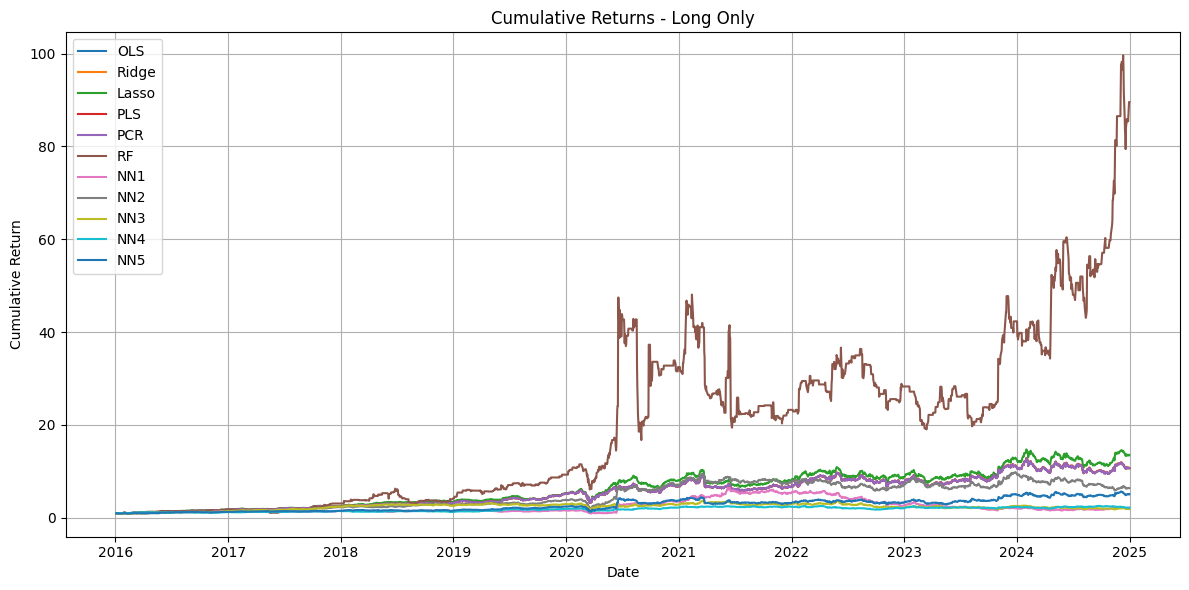

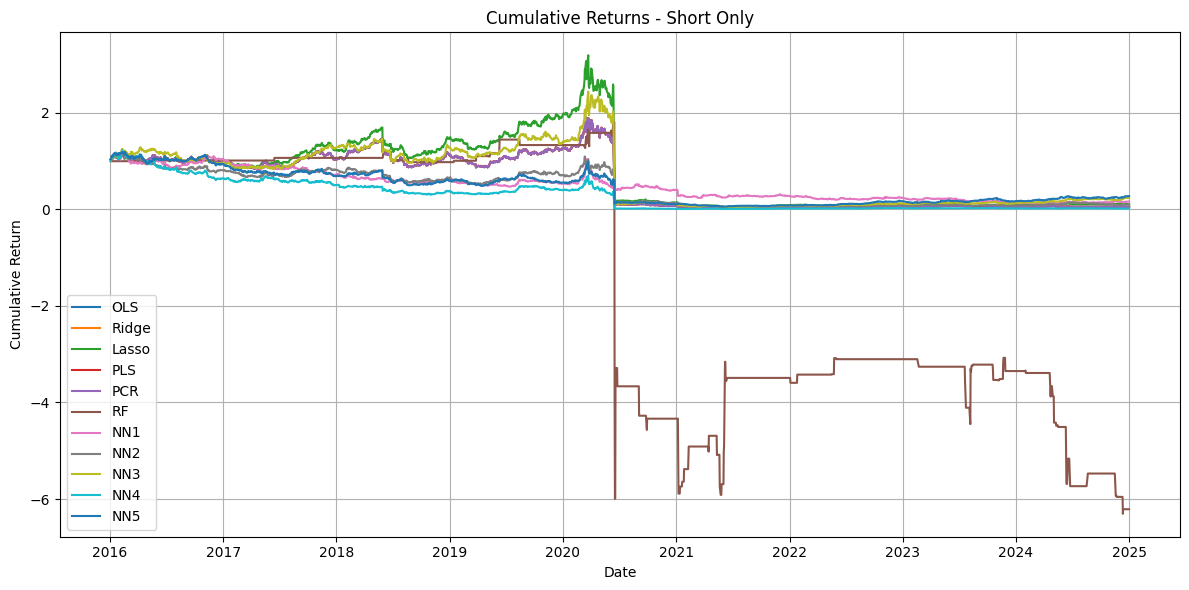

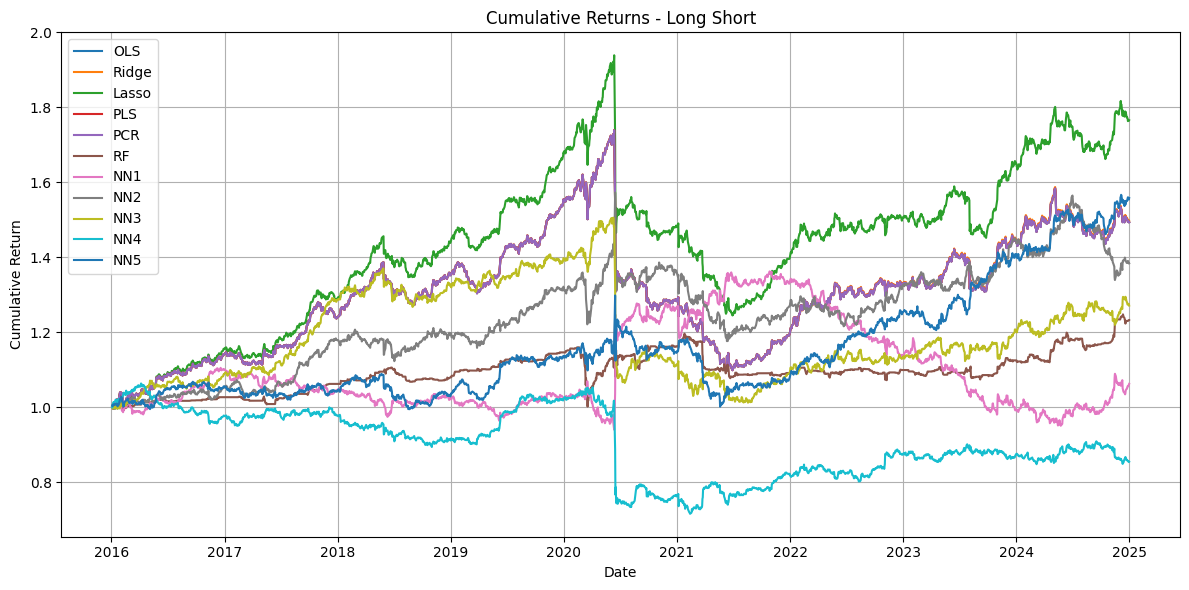

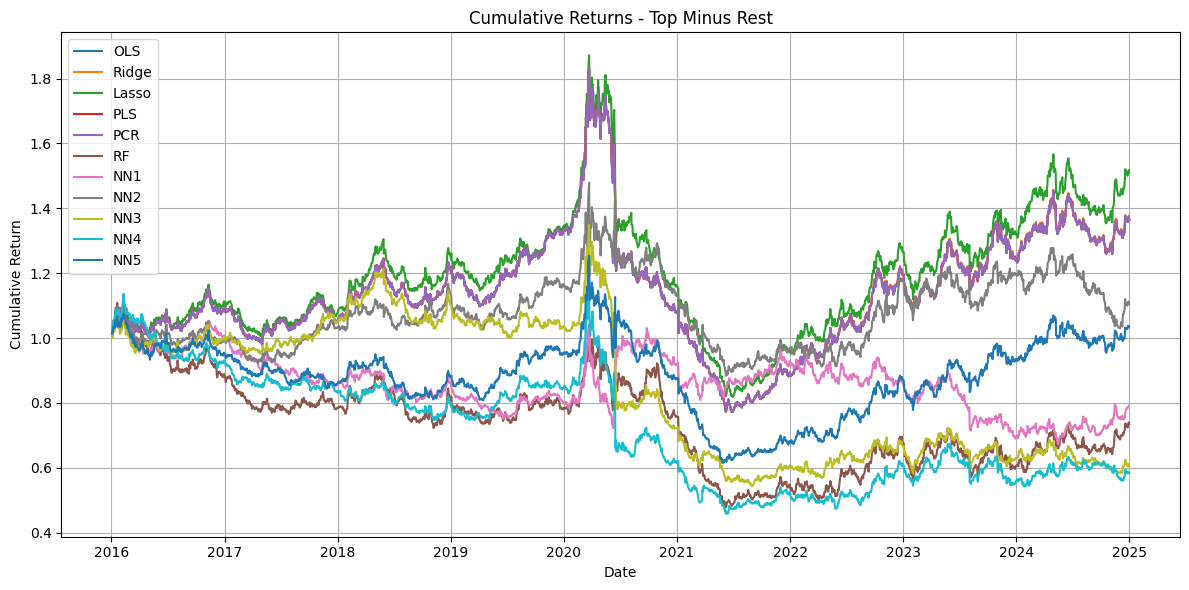

All 4 strategy graphs saved in 'Results' folder.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load predicted data
df = pd.read_csv("results_oos_pred.csv")
df['date'] = pd.to_datetime(df['date'])
df_pred_nn = pd.read_csv("results_oos_pred_nn.csv")
df_pred_nn['date'] = pd.to_datetime(df_pred_nn['date'])

df_pred_subset = df_pred_nn[['PERMNO', 'date'] + list(df_pred_nn.columns[-20:])]

df_merged = pd.merge(df, df_pred_subset, on=['PERMNO', 'date'], how='left')
print(df_merged.columns)
display(df_merged.head())
# Config
percentile = 0.2
predicted_cols = [col for col in df_merged.columns if col.endswith("predicted_window5")]
strategy_names = ['LONG_ONLY', 'SHORT_ONLY', 'LONG_SHORT', 'TOP_MINUS_REST']

# Initialize dictionary to store cumulative returns for each strategy
strategy_cum_returns = {strategy: pd.DataFrame() for strategy in strategy_names}

for col in predicted_cols:
    model_name = col.replace('_predicted_window5', '')
    temp = df_merged[['date', 'PERMNO', 'EXCESS_RET', col]].copy()
    temp.rename(columns={col: 'PRED'}, inplace=True)

    temp['RANK'] = temp.groupby('date')['PRED'].transform(lambda x: x.rank(pct=True))

    temp['LONG_ONLY'] = np.where(temp['RANK'] >= 1 - percentile, temp['EXCESS_RET'], np.nan)
    temp['SHORT_ONLY'] = np.where(temp['RANK'] <= percentile, -temp['EXCESS_RET'], np.nan)
    temp['LONG_SHORT'] = np.where(temp['RANK'] >= 1 - percentile, temp['EXCESS_RET'], 0) + \
                         np.where(temp['RANK'] <= percentile, -temp['EXCESS_RET'], 0)
    temp['TOP_MINUS_REST'] = np.where(temp['RANK'] >= 1 - percentile, temp['EXCESS_RET'], 0) - \
                             np.where((temp['RANK'] < 1 - percentile), temp['EXCESS_RET'], 0)

    # Group by date and compute daily mean returns
    daily_returns = temp.groupby('date')[strategy_names].mean()
    cumulative_returns = (1 + daily_returns.fillna(0)).cumprod()

    for strategy in strategy_names:
        strategy_cum_returns[strategy][model_name] = cumulative_returns[strategy]

# Plot all models in each strategy
import os
os.makedirs("Results", exist_ok=True)

for strategy in strategy_names:
    plt.figure(figsize=(12, 6))
    for model in strategy_cum_returns[strategy].columns:
        plt.plot(strategy_cum_returns[strategy].index, strategy_cum_returns[strategy][model], label=model)
    plt.title(f'Cumulative Returns - {strategy.replace("_", " ").title()}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"Results/cumulative_{strategy.lower()}.png")
    plt.close()

print("All 4 strategy graphs saved in 'Results' folder.")


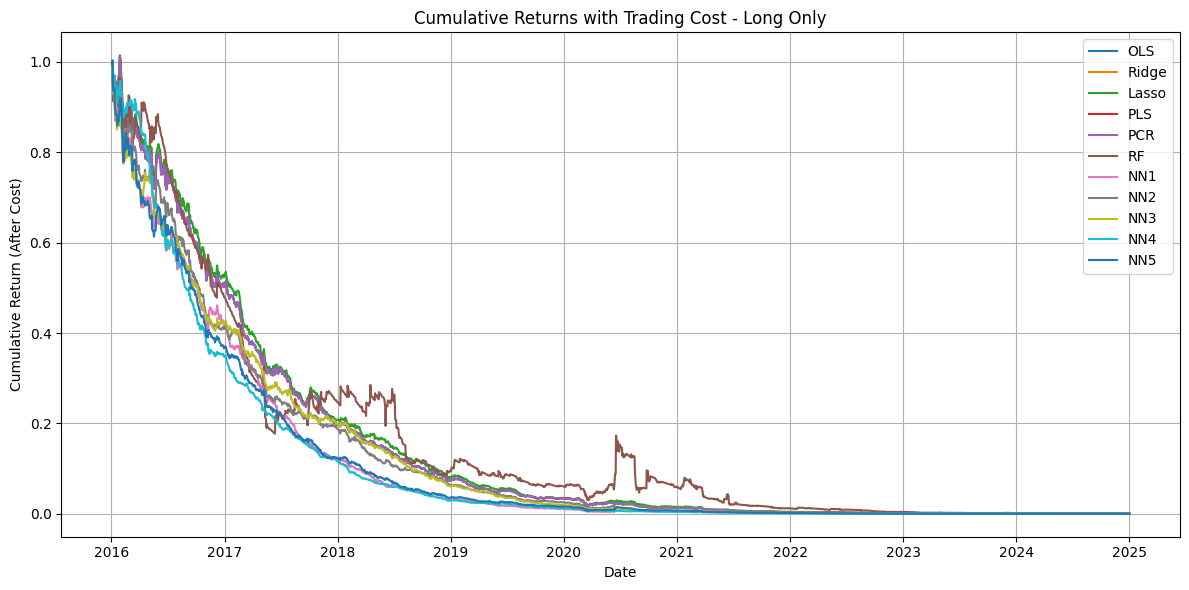

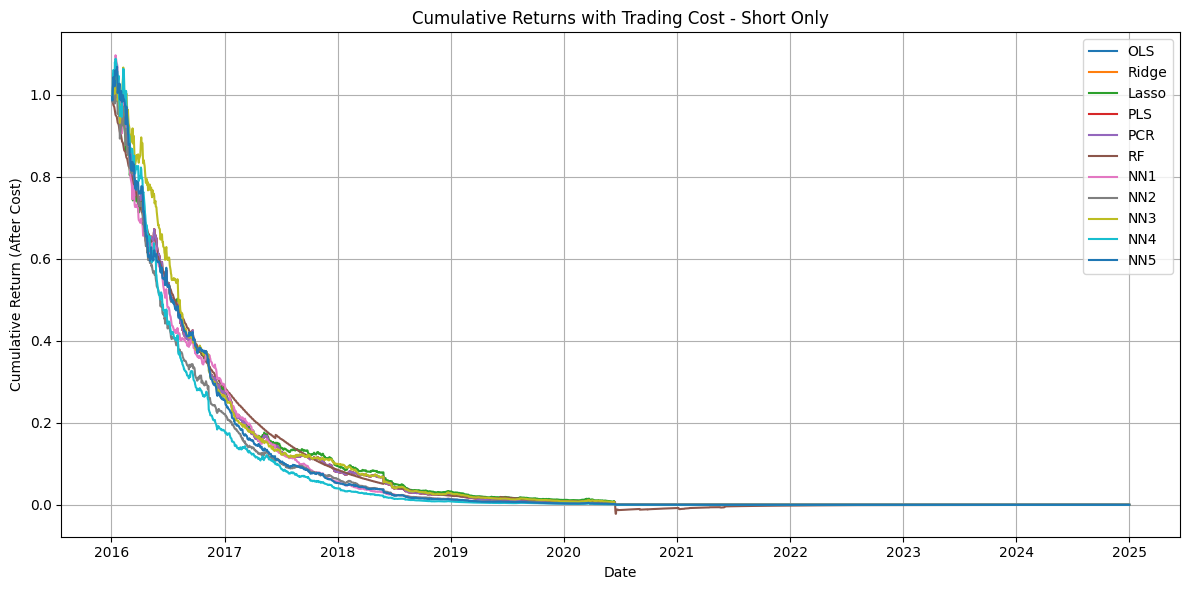

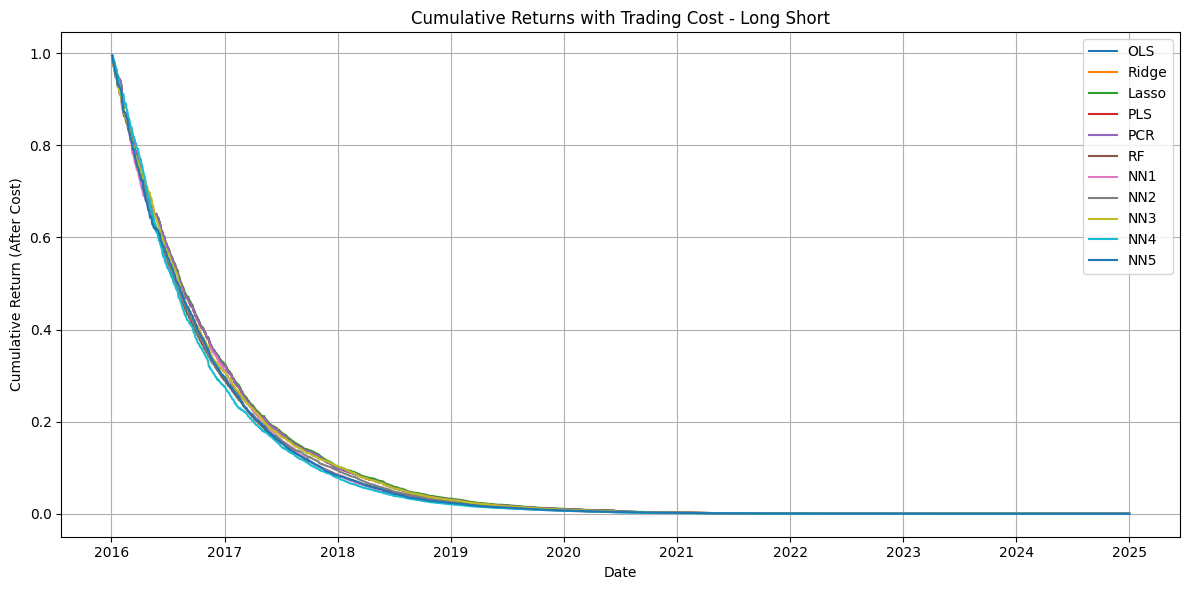

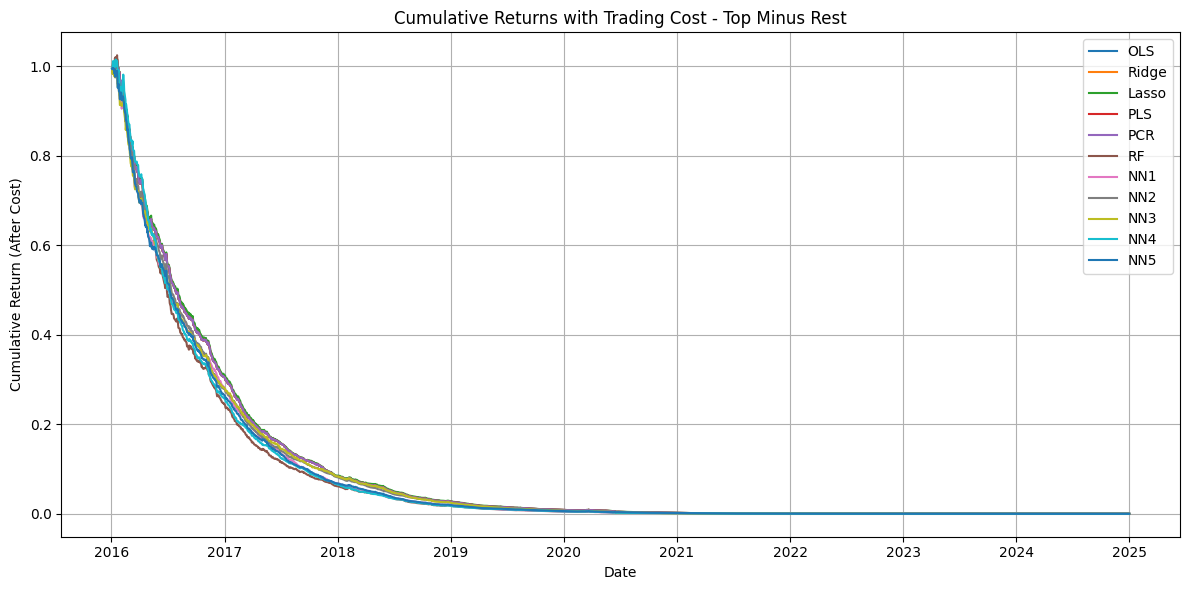

In [12]:
TRADING_COST_PER_SIDE = 0.0025  # 0.25%
DAILY_COST = TRADING_COST_PER_SIDE * 2  # Round-trip

for strategy in strategy_names:
    raw = strategy_cum_returns[strategy]
    cost_adj = raw.copy()

    # Apply constant daily cost to each active strategy
    for model in raw.columns:
        daily_returns = raw[model].pct_change().fillna(0)
        net_returns = daily_returns - DAILY_COST
        cost_adj[model] = (1 + net_returns).cumprod()

    # Plot with trading cost
    plt.figure(figsize=(12, 6))
    for model in cost_adj.columns:
        plt.plot(cost_adj.index, cost_adj[model], label=model)
    plt.title(f'Cumulative Returns with Trading Cost - {strategy.replace("_", " ").title()}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (After Cost)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"Results/cumulative_{strategy.lower()}_with_cost.png")
    plt.close()
